In [1]:
import os
import json
from ape import networks
import pandas as pd
import matplotlib.pyplot as plt
from GeckoTerminal.models.API import fetch_prices, fetch_networks
from CreditGuild.models.CreditToken import CreditToken

# Load addresses
with open('CreditGuild/addresses.json', 'r') as file:
    addresses = json.load(file)

token_address = addresses.get('token_address')
credit_token_map = addresses.get('credit_token_map')

top_addresses = addresses.get('top_addresses')

top_addresses_df = pd.DataFrame(top_addresses)

In [3]:
prices = []

for token in credit_token_map:
    if 'address' in token:
        price = fetch_prices('arbitrum', token['address'])
        if not price is None:
            prices.append({"price": price, "address": token['address']})

credit_token_df = pd.merge(pd.DataFrame(credit_token_map), pd.DataFrame(prices), on='address', how='left')

In [15]:
holdings = pd.DataFrame()

with networks.parse_network_choice("arbitrum:mainnet:infura") as provider:
    for user in top_addresses:
        addr = user['address']
        for token in credit_token_map:
            credit_token = CreditToken(token['creditToken'])
            balance = credit_token.balance_of(addr)
            if balance > 0:
                row = pd.DataFrame([{'user': user['nickname'], 'creditToken': token['creditToken'], 'balance': balance}])
                holdings = pd.concat([holdings, row], ignore_index=True)


In [16]:
users_holdings = pd.merge(holdings, credit_token_df, on='creditToken', how='left')
users_holdings['balance'] = users_holdings['balance'].astype(float)

users_holdings['value'] = users_holdings['balance'] * users_holdings['price']

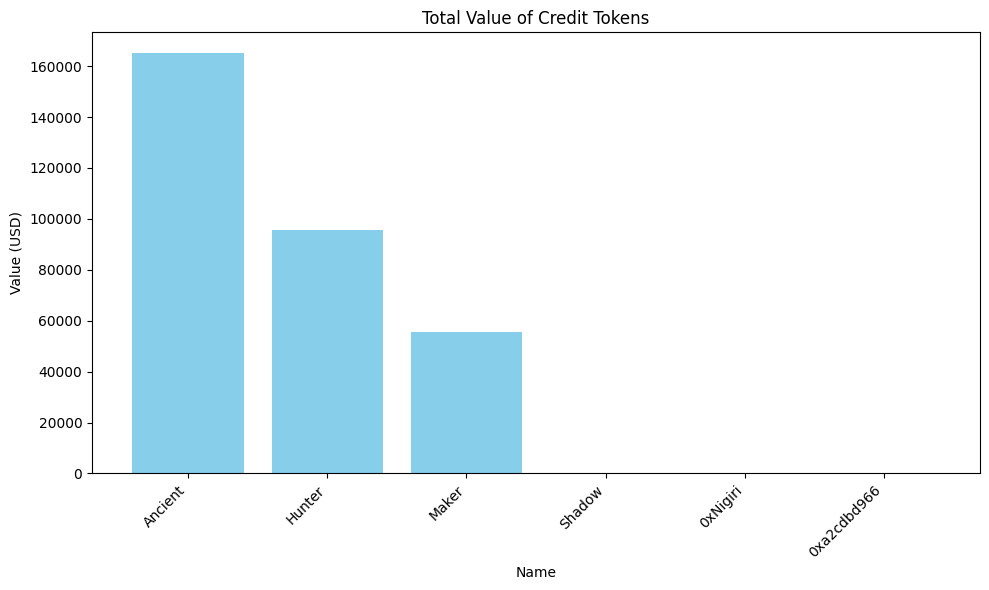

In [19]:
grouped_holdings = users_holdings.groupby('user')['value'].sum().reset_index()
grouped_holdings = grouped_holdings.sort_values(by='value', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(grouped_holdings['user'], grouped_holdings['value'], color='skyblue')
plt.xlabel('Name')
plt.ylabel('Value (USD)')
plt.title('Total Value of Credit Tokens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:

with networks.parse_network_choice("arbitrum:mainnet:infura") as provider:
    addr = "0x6b0e55f66add3861ffaa1e7137fa659abe530b8d"
    for token in credit_token_map:
        credit_token = CreditToken(token['creditToken'])
        balance = credit_token.balance_of(addr)
        if balance > 0:
            print({'creditToken': token['creditToken'], 'balance': balance})


{'creditToken': '0xD5FD8456aa96aAA07c23605e9a8d2ce5f737F145', 'balance': Decimal('80719.888825394901956099')}
{'creditToken': '0xaFBe44E79E9affB25CEd16D971933219d1d6EC8d', 'balance': Decimal('0.00621283529179831')}
{'creditToken': '0xb6CC9BbD136Bde153c380a987EF6b365bA9f7669', 'balance': Decimal('14996.999591800676738567')}
